# Setup and load data:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/colab-github/move/dance

import os
import sys
import warnings

print(os.getcwd())

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

/content/drive/.shortcut-targets-by-id/1-DJonK3jse0NWdbyWWAIrK_srm2hV5ug/move/dance
/content/drive/.shortcut-targets-by-id/1-DJonK3jse0NWdbyWWAIrK_srm2hV5ug/move/dance


In [4]:
!which ffmpeg

/usr/bin/ffmpeg


In [5]:
import matplotlib.animation
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # for using html5 video in Jupyter notebook
print(matplotlib.animation.writers.list()) # check that ffmpeg is loaded. if it's not there, use .to_jshtml() instead of .to_html5_video().

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


In [6]:
%cd /content/drive/MyDrive/colab-github/move/dance

/content/drive/.shortcut-targets-by-id/1-DJonK3jse0NWdbyWWAIrK_srm2hV5ug/move/dance


In [7]:
import math

In [8]:
import numpy as np 
from functions.functions import load_data

data_new = load_data('rnn_data/mariel_beyond.npy')

Files loaded: ['rnn_data/mariel_beyond.npy']


In [9]:
print(type(data_new))
print(type(data_new.full))
print(type(data_new.full.X))
data_new.full.X.shape

<class 'functions.functions.Data'>
<class 'functions.functions.Dataset'>
<class 'numpy.ndarray'>


(53, 6803, 3)

# Check out the real data:

In [10]:
from IPython.display import HTML
from functions.plotting import animate

frame = np.random.randint(0, data_new.full.X.shape[1]-50)
print("Starting from frame {}...".format(frame))

HTML(animate(data_new.full.X[:,frame:,:], frames=100))
# HTML(animate(data.selected.X[:,frame:,:], frames=100, edges=data.selected.edges, colors='black'))

Starting from frame 5960...


# Build the autoencoder for poses

### Define the training dataset:

In [11]:
# X_train = data.selected.X    # 15 joints
X_train = data.full.X[:,:int(data.full.X.shape[1]*.8),:]    # 53 joints (80% train)
X_test = data.full.X[:,int(data.full.X.shape[1]*.8):,:]    # 53 joints (20% test)
print("Training set size: {}".format(X_train.shape))
print("Test set size: {}".format(X_test.shape))

NameError: ignored



### Write Torch Autoencoder

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init



In [13]:

class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """
    def reparametrize(self, mu, log_var):
        epsilon = Variable(torch.randn(mu.size()), requires_grad=False)

        if mu.is_cuda:
            epsilon = epsilon.cuda()

        # log_std = 0.5 * log_var
        # std = exp(log_std)
        std = log_var.mul(0.5).exp_()

        # z = std * epsilon + mu
        z = mu.addcmul(std, epsilon)

        return z

class GaussianSample(Stochastic):
    """
    Layer that represents a sample from a
    Gaussian distribution.
    """
    def __init__(self, in_features, out_features):
        super(GaussianSample, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.mu = nn.Linear(in_features, out_features)
        self.log_var = nn.Linear(in_features, out_features)

    def forward(self, x):
        mu = self.mu(x)
        log_var = F.softplus(self.log_var(x))

        return self.reparametrize(mu, log_var), mu, log_var


In [14]:


class Encoder(nn.Module):
    def __init__(self, dims, sample_layer=GaussianSample):
        """
        Inference network
        Attempts to infer the probability distribution
        p(z|x) from the data by fitting a variational
        distribution q_φ(z|x). Returns the two parameters
        of the distribution (µ, log σ²).
        :param dims: dimensions of the networks
           given by the number of neurons on the form
           [input_dim, [hidden_dims], latent_dim].
        """
        super(Encoder, self).__init__()

        [x_dim, h_dim, z_dim] = dims
        neurons = [x_dim, *h_dim]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(linear_layers)
        self.sample = sample_layer(h_dim[-1], z_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        return self.sample(x)

In [62]:
MARIEL_N_UNITS = 64
MARIEL_N_LAYERS = 2
MARIEL_Z_DIM = 32

H_DIM = [MARIEL_N_UNITS,] * MARIEL_N_LAYERS
print(H_DIM)

my_encoder = Encoder((159, H_DIM, MARIEL_Z_DIM))

[64, 64]


In [64]:

class Decoder(nn.Module):
    def __init__(self, dims):
        """
        Generative network
        Generates samples from the original distribution
        p(x) by transforming a latent representation, e.g.
        by finding p_θ(x|z).
        :param dims: dimensions of the networks
            given by the number of neurons on the form
            [latent_dim, [hidden_dims], input_dim].
        """
        super(Decoder, self).__init__()

        [z_dim, h_dim, x_dim] = dims

        neurons = [z_dim, *h_dim]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)

        self.reconstruction = nn.Linear(h_dim[-1], x_dim)

        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        return self.output_activation(self.reconstruction(x))


In [66]:
def log_gaussian(x, mu, log_var):
    """
    Returns the log pdf of a normal distribution parametrised
    by mu and log_var evaluated at x.
    :param x: point to evaluate
    :param mu: mean of distribution
    :param log_var: log variance of distribution
    :return: log N(x|µ,σ)
    """
    log_pdf = - 0.5 * math.log(2 * math.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
    return torch.sum(log_pdf, dim=-1)

In [67]:
def log_standard_gaussian(x):
    """
    Evaluates the log pdf of a standard normal distribution at x.
    :param x: point to evaluate
    :return: log N(x|0,I)
    """
    return torch.sum(-0.5 * math.log(2 * math.pi) - x ** 2 / 2, dim=-1)

In [68]:

class VariationalAutoencoder(nn.Module):
    def __init__(self, dims):
        """
        Variational Autoencoder [Kingma 2013] model
        consisting of an encoder/decoder pair for which
        a variational distribution is fitted to the
        encoder. Also known as the M1 model in [Kingma 2014].
        :param dims: x, z and hidden dimensions of the networks
        """
        super(VariationalAutoencoder, self).__init__()

        [x_dim, z_dim, h_dim] = dims
        self.z_dim = z_dim
        self.flow = None

        self.encoder = Encoder([x_dim, h_dim, z_dim])
        self.decoder = Decoder([z_dim, list(reversed(h_dim)), x_dim])
        self.kl_divergence = 0

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _kld(self, z, q_param, p_param=None):
        """
        Computes the KL-divergence of
        some element z.
        KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
                 = -E[log p(z) - log q(z)]
        :param z: sample from q-distribuion
        :param q_param: (mu, log_var) of the q-distribution
        :param p_param: (mu, log_var) of the p-distribution
        :return: KL(q||p)
        """

        (mu, log_var) = q_param

        if self.flow is not None:
            f_z, log_det_z = self.flow(z)
            qz = log_gaussian(z, mu, log_var) - sum(log_det_z)
            z = f_z
        else:
            qz = log_gaussian(z, mu, log_var)

        if p_param is None:
            pz = log_standard_gaussian(z)
        else:
            (mu, log_var) = p_param
            pz = log_gaussian(z, mu, log_var)

        kl = qz - pz

        return kl

    def elbo(self, x_in, x_out, z, q_param, p_param=None):
        recon_loss = torch.sum(torch.norm((x_in - x_out))**2)
        regul_loss = self._kld(z, q_param, p_param)
        return recon_loss + regul_loss

    def add_flow(self, flow):
        self.flow = flow

    def forward(self, x, y=None):
        """
        Runs a data point through the model in order
        to provide its reconstruction and q distribution
        parameters.
        :param x: input data
        :return: reconstructed input
        """
        z, z_mu, z_log_var = self.encoder(x)

        self.kl_divergence = self._kld(z, (z_mu, z_log_var))

        x_mu = self.decoder(z)

        return x_mu, z, z_mu, z_log_var

    def sample(self, z):
        """
        Given z ~ N(0, I) generates a sample from
        the learned distribution based on p_θ(x|z).
        :param z: (torch.autograd.Variable) Random normal variable
        :return: (torch.autograd.Variable) generated sample
        """
        return self.decoder(z)


# Running the Autoencoder

Set the batch size and learning rate.

In [156]:
batchsize = 2
learning_rate= 3e-5

In [157]:
my_data = data_new.full.X.transpose((1,0,2))

data_torch = torch.utils.data.DataLoader(
    my_data.reshape((my_data.shape[0], -1)), batch_size=batchsize, num_workers=2)

x_input = torch.tensor(data_torch.dataset, dtype=torch.float32)


In [158]:
z_torch, mu, logvar = my_encoder(x_input)
z_torch.shape

torch.Size([6803, 32])

In [159]:
my_decoder = Decoder([MARIEL_Z_DIM, H_DIM, 159])
x_recon = my_decoder(z_torch)
x_recon_pose = x_recon.reshape((53, x_recon.shape[0] ,3))
print(x_recon.shape)
print(x_recon_pose.shape)

torch.Size([6803, 159])
torch.Size([53, 6803, 3])


In [160]:
my_vae = VariationalAutoencoder([159, MARIEL_Z_DIM, H_DIM])
print(x_input.shape)
for x in data_torch:
  x_recon_dir = my_vae(x.float())

torch.Size([6803, 159])


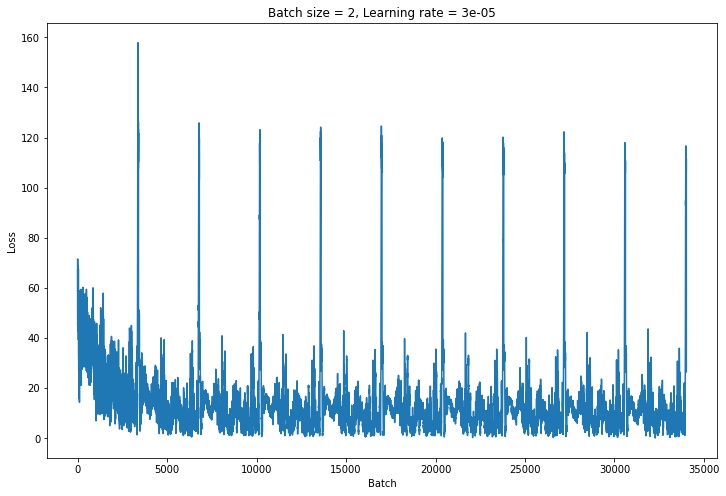

In [161]:
model = my_vae
from torch.autograd import Variable

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_array=[]


for epoch in range(10):
    model.train()
    total_loss = 0
    for x in data_torch:
        x = Variable(x)

        x_recon, z, z_mu, z_logvar = my_vae(x.float())

        loss = torch.sum(model.elbo(x, x_recon, z, (z_mu, z_logvar)))
        loss.backward()
        loss_array.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss


loss_real_array = np.asarray(loss_array)
x_axis = np.arange(0, len(loss_real_array))
plt.figure(figsize=(12,8))
plt.plot(x_axis, loss_real_array)
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.title('Batch size = {}, Learning rate = {}'.format(batchsize, learning_rate))
plt.savefig('/content/drive/MyDrive/colab-github/move/dance/Training_Loss_vs_Batch/batch_{}_lr_{}.png'.format(batchsize, learning_rate))      

Text(0.5, 1.0, 'Batch size = 3, Learning rate = 3e-05')

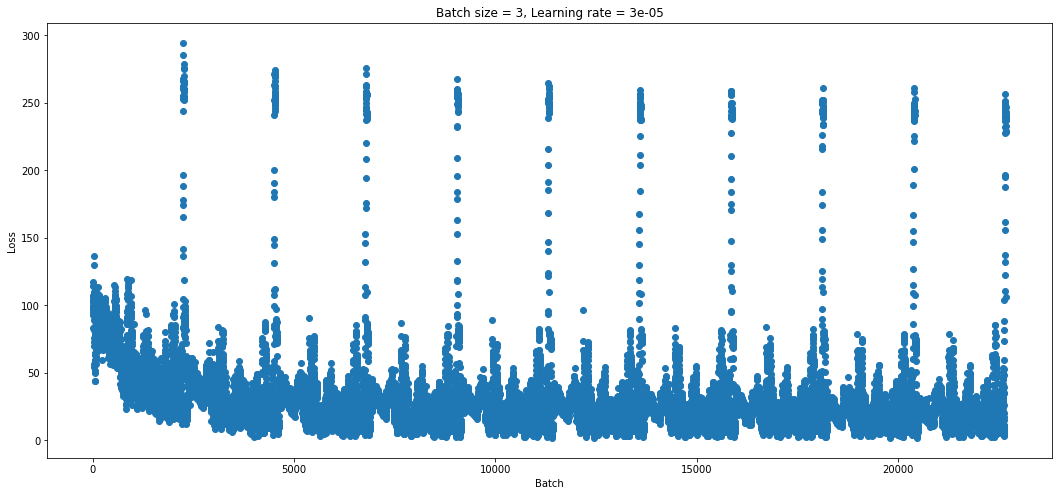

In [155]:
loss_real_array = np.asarray(loss_array)
x_axis = np.arange(0, len(loss_real_array))
plt.figure(figsize=(18,8))
plt.scatter(x_axis, loss_real_array)
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.title('Batch size = {}, Learning rate = {}'.format(batchsize, learning_rate))

## Mariel's Autoencoder

In [ ]:
import numpy as np
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Input, Lambda, LeakyReLU, Reshape
from keras.models import Model
from tensorflow.keras.optimizers import Adam


class Autoencoder:
    def __init__(
        self,
        n_verts=0,
        n_dims=3,
        latent_dim=2,
        n_layers=2,
        n_units=128,
        relu=False,
        add_random_offsets=False,
        dropout=False,
    ):
        if not n_verts:
            raise Exception("Please provide the number of vertices `n_verts`")
        self.n_verts = n_verts  # input vert count
        self.n_dims = n_dims  # input dimensions
        self.relu = relu
        # whether to add relu layers in encoder/decoder
        self.dropout = dropout  # whether to add dropout layers in encoder/decoder
        self.latent_dim = latent_dim
        self.n_layers = n_layers
        self.n_units = n_units
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        # attach the encoder and decoder
        i = Input((self.n_verts, self.n_dims))
        if add_random_offsets:
            random_offsets = (
                K.cast(K.learning_phase(), "float")
                * K.random_uniform((K.shape(i)[0], 1, 3))
                * K.constant([[[1, 1, 0]]])
            )
            offset_layer = Lambda(lambda x: x + random_offsets)
            offset_layer.uses_learning_phase = True
            i_offset = offset_layer(i)
        else:
            i_offset = i
        z = self.encoder(i_offset)  # push observations into latent space
        o = self.decoder(z)  # project from latent space to feature space
        if add_random_offsets:
            o = Lambda(lambda x: x - random_offsets)(o)
        self.model = Model(inputs=[i], outputs=[o])
        self.model.compile(loss="mse", optimizer=Adam(lr=1e-4))

    def build_encoder(self):
        i = Input((self.n_verts, self.n_dims))
        h = i
        h = Flatten()(h)
        for _ in range(self.n_layers):
            h = Dense(self.n_units)(h)
            if self.relu:
                h = LeakyReLU(alpha=0.2)(h)
            if self.dropout:
                h = Dropout(0.4)(h)
        o = Dense(self.latent_dim)(h)
        return Model(inputs=[i], outputs=[o])

    def build_decoder(self):
        i = Input((self.latent_dim,))
        h = i
        for _ in range(self.n_layers):
            h = Dense(self.n_units)(h)
            if self.relu:
                h = LeakyReLU(alpha=0.2)(h)
            if self.dropout:
                h = Dropout(0.4)(h)
        h = Dense(self.n_verts * self.n_dims)(h)
        o = Reshape((self.n_verts, self.n_dims))(h)  # predict 1 frame
        return Model(inputs=[i], outputs=[o])

    def train(self, X, n_epochs=10000):
        for idx in range(n_epochs):
            i = np.random.randint(0, X.shape[1] - 1)  # sample idx
            frame = np.expand_dims(
                X[:, i : i + 1, :].squeeze(), axis=0
            )  # shape = 1 sample, v verts, d dims
            loss = self.model.train_on_batch(frame, frame)
            if idx == 0:
                print(frame.shape)
            if idx % 1000 == 0:
                print(" * training idx", idx, "loss", loss)

    def get_predictions(self, X, n_frames=50, start_frame=0):
        """Return the model's predictions of observations from X in shape of X"""
        predictions = []
        for i in range(start_frame, start_frame + n_frames, 1):
            x = np.expand_dims(X[:, i : i + 1, :].squeeze(), axis=0)
            predictions.append(self.model.predict(x))
        return np.swapaxes(np.vstack(predictions), 0, 1)
